# Data

## Load the data

In [1]:
"""
    Download and save raw market data CSV
"""

import pandas as pd
import logging
import os

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Download and save CSV. One time only
logger.info("Downloading power data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
local_path = "data/power_data_raw.csv"

os.makedirs("data", exist_ok=True)

if os.path.exists(local_path):
    logger.info("File exists. Reading local CSV...")
    df = pd.read_csv(local_path)
else:
    df = pd.read_csv(url)
    logger.info("Saving to data/power_data_raw.csv")
    os.makedirs("data", exist_ok=True)
    df.to_csv("data/power_data_raw.csv", index=False)

logger.info("Process completed.")

2025-12-08 23:44:31,594 | INFO | Downloading power data...
2025-12-08 23:44:31,595 | INFO | File exists. Reading local CSV...
2025-12-08 23:44:32,064 | INFO | Process completed.


## Get Austria's Values

In [2]:
print(df.head())
with open("data/all_column_names.txt", "w") as f:
    for col in df.columns:
        f.write(f"{col}\n")

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB


## Set Index

In [4]:
at_cols = df.columns[df.columns.str.startswith("AT_")]
selected_cols = ["utc_timestamp"] + list(at_cols) # Desired Columns
df_selected = df[selected_cols].copy()
df_selected = df_selected.drop(["AT_load_actual_entsoe_transparency"], axis=1)
df_selected["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"]) # Datetime Timestamp
df_selected = df_selected.set_index("utc_timestamp") # Timestamp as index
print(df_selected.head(1))

                           AT_load_forecast_entsoe_transparency  \
utc_timestamp                                                     
2014-12-31 23:00:00+00:00                                   NaN   

                           AT_price_day_ahead  AT_solar_generation_actual  \
utc_timestamp                                                               
2014-12-31 23:00:00+00:00                 NaN                         NaN   

                           AT_wind_onshore_generation_actual  
utc_timestamp                                                 
2014-12-31 23:00:00+00:00                                NaN  


### We keep only the columns that we are interested in. We keep the actuals that do not have a forecast to lag them by 24 hours. The actuals that have a forecast columns are dropped.

## Enforce Hourly Frequency

In [5]:
full_idx = pd.date_range(
    start=df_selected.index.min(),
    end=df_selected.index.max(),
    freq="h",
    tz=df_selected.index.tz
)
df_selected = df_selected.reindex(full_idx)

## Slice the Dataset to Valid start and finish

In [6]:
important_cols = ["AT_load_forecast_entsoe_transparency", "AT_price_day_ahead", "AT_wind_onshore_generation_actual", "AT_solar_generation_actual"]

In [7]:
first_valid_indices = df_selected[important_cols].apply(lambda col: col.first_valid_index())
last_valid_indices = df_selected[important_cols].apply(lambda col: col.last_valid_index())

print("First valid data points:")
print(first_valid_indices)

First valid data points:
AT_load_forecast_entsoe_transparency   2015-01-01 00:00:00+00:00
AT_price_day_ahead                     2015-01-01 00:00:00+00:00
AT_wind_onshore_generation_actual      2015-01-01 00:00:00+00:00
AT_solar_generation_actual             2015-01-01 07:00:00+00:00
dtype: datetime64[ns, UTC]


In [8]:
print(last_valid_indices)

AT_load_forecast_entsoe_transparency   2020-09-30 23:00:00+00:00
AT_price_day_ahead                     2018-10-02 21:00:00+00:00
AT_wind_onshore_generation_actual      2020-09-30 23:00:00+00:00
AT_solar_generation_actual             2020-09-30 17:00:00+00:00
dtype: datetime64[ns, UTC]


In [9]:
global_start = first_valid_indices.max()
global_end = last_valid_indices.min()

print(f"\nSlicing Data to Common Range: {global_start} to {global_end}")


Slicing Data to Common Range: 2015-01-01 07:00:00+00:00 to 2018-10-02 21:00:00+00:00


In [10]:
df_clean = df_selected.loc[global_start: global_end].copy()
print(df_clean.isna().sum())

AT_load_forecast_entsoe_transparency     0
AT_price_day_ahead                      57
AT_solar_generation_actual              48
AT_wind_onshore_generation_actual       48
dtype: int64


## Feature Engineering

### Lagged actuals (24h) (Missing Forecasts)

In [11]:
df_clean["AT_wind_onshore_lag24"] = df_clean["AT_wind_onshore_generation_actual"].shift(24)
df_clean["AT_solar_generation_lag24"] = df_clean["AT_solar_generation_actual"].shift(24)

df_clean = df_clean.drop(columns=["AT_solar_generation_actual", "AT_wind_onshore_generation_actual"])

### 24-hour SMA and 24-hour EMA for load

In [12]:
df_clean["AT_load_rolling24h"] = df_clean["AT_load_forecast_entsoe_transparency"].rolling(window=24).mean()
df_clean["AT_load_ema24h"] = df_clean["AT_load_forecast_entsoe_transparency"].ewm(span=24, adjust=False).mean()

df_clean = df_clean.dropna(subset=["AT_load_rolling24h", "AT_load_ema24h"])

### Hour and weekday

In [13]:
df_clean["hour"] = df_clean.index.hour
df_clean["weekday"] = df_clean.index.dayofweek

In [14]:
import numpy as np

# 1. Transform Hour (Period = 24)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24.0)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24.0)

# 2. Transform Weekday (Period = 7)
# Note: Python's dayofweek is 0 (Mon) to 6 (Sun)
df_clean['weekday_sin'] = np.sin(2 * np.pi * df_clean['weekday'] / 7.0)
df_clean['weekday_cos'] = np.cos(2 * np.pi * df_clean['weekday'] / 7.0)

## Split the Data into Training and Testing Sets

In [15]:
TEST_WEEKS = 2
TEST_HOURS = 24 * 7 * TEST_WEEKS

split_cutoff_index = len(df_clean) - TEST_HOURS
split_date = df_clean.index[split_cutoff_index]

logger.info(f"Training Data Ends: {split_date}")
logger.info(f"Test Data Starts: {split_date}")
logger.info(f"Test Duration: {TEST_HOURS} hours")

train_set = df_clean.iloc[:split_cutoff_index]
test_set = df_clean.iloc[split_cutoff_index:]

2025-12-08 23:44:32,180 | INFO | Training Data Ends: 2018-09-18 22:00:00+00:00
2025-12-08 23:44:32,181 | INFO | Test Data Starts: 2018-09-18 22:00:00+00:00
2025-12-08 23:44:32,181 | INFO | Test Duration: 336 hours


## Clean Training and Test Data

In [16]:
def get_max_consecutive_nans(series):
    # Create a boolean mask where True is NaN
    mask = series.isna()
    # Group consecutive True/False values and count them
    # We only keep the groups that are NaN (True)
    consecutive_counts = mask.groupby((mask != mask.shift()).cumsum()).sum()
    # Return the max
    return consecutive_counts[mask.groupby((mask != mask.shift()).cumsum()).first()].max()

# Apply to train set
for col in train_set.columns:
    x_max_gap_train = get_max_consecutive_nans(train_set[col])
    print(f"TRAIN: {col}: Max consecutive NaNs = {x_max_gap_train}")
    x_max_gap_test = get_max_consecutive_nans(test_set[col])
    print(f"TEST: {col}: Max test concecutive NaNs = {x_max_gap_test}")

TRAIN: AT_load_forecast_entsoe_transparency: Max consecutive NaNs = nan
TEST: AT_load_forecast_entsoe_transparency: Max test concecutive NaNs = nan
TRAIN: AT_price_day_ahead: Max consecutive NaNs = 24
TEST: AT_price_day_ahead: Max test concecutive NaNs = nan
TRAIN: AT_wind_onshore_lag24: Max consecutive NaNs = 24
TEST: AT_wind_onshore_lag24: Max test concecutive NaNs = nan
TRAIN: AT_solar_generation_lag24: Max consecutive NaNs = 24
TEST: AT_solar_generation_lag24: Max test concecutive NaNs = nan
TRAIN: AT_load_rolling24h: Max consecutive NaNs = nan
TEST: AT_load_rolling24h: Max test concecutive NaNs = nan
TRAIN: AT_load_ema24h: Max consecutive NaNs = nan
TEST: AT_load_ema24h: Max test concecutive NaNs = nan
TRAIN: hour: Max consecutive NaNs = nan
TEST: hour: Max test concecutive NaNs = nan
TRAIN: weekday: Max consecutive NaNs = nan
TEST: weekday: Max test concecutive NaNs = nan
TRAIN: hour_sin: Max consecutive NaNs = nan
TEST: hour_sin: Max test concecutive NaNs = nan
TRAIN: hour_cos: 

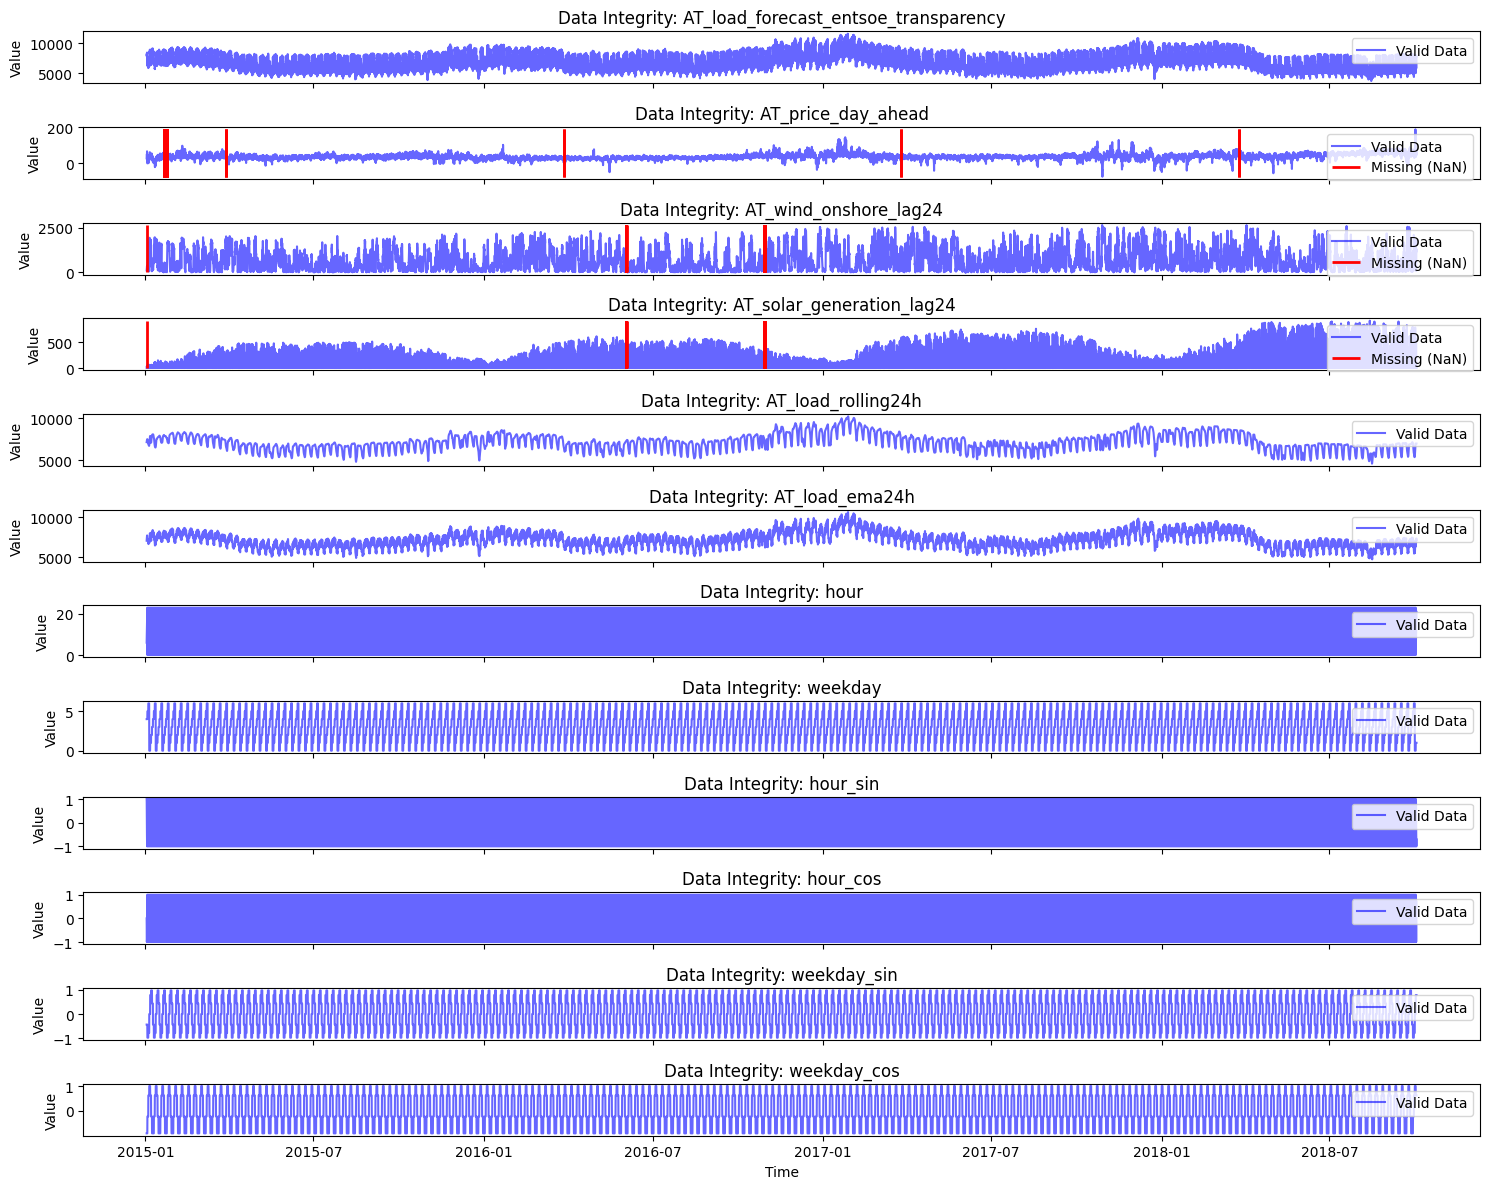

In [ ]:
import matplotlib.pyplot as plt

# The columns we care about
cols_to_check = df_clean.columns

# Create a figure with one subplot for each column
fig, axes = plt.subplots(nrows=len(cols_to_check), ncols=1, figsize=(15, 12), sharex=True)

for i, col in enumerate(cols_to_check):
    # 1. Get data
    valid_data = df_clean[col]
    missing_data = df_clean[df_clean[col].isna()]
    
    # 2. Calculate ranges for plotting
    d_min = valid_data.min()
    d_max = valid_data.max()
    
    # 3. Plot Valid Data
    axes[i].plot(valid_data.index, valid_data, label="Valid Data", color="blue", alpha=0.6)
    
    # 4. Plot Missing Data (The Red Stripes)
    if len(missing_data) > 0:
        axes[i].vlines(
            x=missing_data.index, 
            ymin=d_min, 
            ymax=d_max, 
            colors="red", 
            linewidth=2, 
            label="Missing (NaN)"
        )
    
    axes[i].set_title(f"Data Integrity: {col}")
    axes[i].set_ylabel("Value")
    axes[i].legend(loc="upper right")

plt.xlabel("Time")
plt.tight_layout()
plt.show()

In [18]:
train_set.isna().sum()

AT_load_forecast_entsoe_transparency     0
AT_price_day_ahead                      57
AT_wind_onshore_lag24                   49
AT_solar_generation_lag24               49
AT_load_rolling24h                       0
AT_load_ema24h                           0
hour                                     0
weekday                                  0
hour_sin                                 0
hour_cos                                 0
weekday_sin                              0
weekday_cos                              0
dtype: int64

In [19]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32536 entries, 2015-01-02 06:00:00+00:00 to 2018-09-18 21:00:00+00:00
Freq: h
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AT_load_forecast_entsoe_transparency  32536 non-null  float64
 1   AT_price_day_ahead                    32479 non-null  float64
 2   AT_wind_onshore_lag24                 32487 non-null  float64
 3   AT_solar_generation_lag24             32487 non-null  float64
 4   AT_load_rolling24h                    32536 non-null  float64
 5   AT_load_ema24h                        32536 non-null  float64
 6   hour                                  32536 non-null  int32  
 7   weekday                               32536 non-null  int32  
 8   hour_sin                              32536 non-null  float64
 9   hour_cos                              32536 non-null  float64
 10  weekday_sin                

In [20]:
test_set.isna().sum()

AT_load_forecast_entsoe_transparency    0
AT_price_day_ahead                      0
AT_wind_onshore_lag24                   0
AT_solar_generation_lag24               0
AT_load_rolling24h                      0
AT_load_ema24h                          0
hour                                    0
weekday                                 0
hour_sin                                0
hour_cos                                0
weekday_sin                             0
weekday_cos                             0
dtype: int64

In [21]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 2018-09-18 22:00:00+00:00 to 2018-10-02 21:00:00+00:00
Freq: h
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AT_load_forecast_entsoe_transparency  336 non-null    float64
 1   AT_price_day_ahead                    336 non-null    float64
 2   AT_wind_onshore_lag24                 336 non-null    float64
 3   AT_solar_generation_lag24             336 non-null    float64
 4   AT_load_rolling24h                    336 non-null    float64
 5   AT_load_ema24h                        336 non-null    float64
 6   hour                                  336 non-null    int32  
 7   weekday                               336 non-null    int32  
 8   hour_sin                              336 non-null    float64
 9   hour_cos                              336 non-null    float64
 10  weekday_sin                  

In [22]:
# Custom function to fill NaNs with the value from the same hour 24 hours ago to keep seasonality
def fill_with_seasonal_pattern(df, cols, period=24):
    df_filled = df.copy()
    for col in cols:
        # Fill with value 24h before
        df_filled[col] = df_filled[col].fillna(df_filled[col].shift(period))
        # The remaining fill with with last known value
        df_filled[col] = df_filled[col].ffill()
        # To capture edge cases, use backfill (Training and Testing data already split)
        df_filled[col] = df_filled[col].bfill()

    return df_filled

# First fill yesterday's values
train_set = fill_with_seasonal_pattern(train_set, train_set.columns, period=24)
print(train_set.isna().sum())

AT_load_forecast_entsoe_transparency    0
AT_price_day_ahead                      0
AT_wind_onshore_lag24                   0
AT_solar_generation_lag24               0
AT_load_rolling24h                      0
AT_load_ema24h                          0
hour                                    0
weekday                                 0
hour_sin                                0
hour_cos                                0
weekday_sin                             0
weekday_cos                             0
dtype: int64


In [23]:
train_set.head(30)

,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_lag24,AT_solar_generation_lag24,AT_load_rolling24h,AT_load_ema24h,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
2015-01-02 06:00:00+00:00,8058.0,26.0,109.0,2.0,7147.458333,7058.800833,6,4,1.000000e+00,6.123234e-17,-0.433884,-0.900969
2015-01-02 07:00:00+00:00,8281.0,36.0,109.0,2.0,7198.291667,7156.576767,7,4,9.659258e-01,-2.588190e-01,-0.433884,-0.900969
2015-01-02 08:00:00+00:00,8242.0,42.0,146.0,10.0,7240.333333,7243.410625,8,4,8.660254e-01,-5.000000e-01,-0.433884,-0.900969
2015-01-02 09:00:00+00:00,8240.0,41.0,146.0,21.0,7273.208333,7323.137775,9,4,7.071068e-01,-7.071068e-01,-0.433884,-0.900969
2015-01-02 10:00:00+00:00,8217.0,45.0,158.0,32.0,7301.125000,7394.646753,10,4,5.000000e-01,-8.660254e-01,-0.433884,-0.900969
2015-01-02 11:00:00+00:00,8017.0,47.0,187.0,37.0,7324.583333,7444.435013,11,4,2.588190e-01,-9.659258e-01,-0.433884,-0.900969
2015-01-02 12:00:00+00:00,7835.0,46.0,244.0,35.0,7343.083333,7475.680212,12,4,1.224647e-16,-1.000000e+00,-0.433884,-0.900969
2015-01-02 13:00:00+00:00,7789.0,44.0,299.0,27.0,7362.791667,7500.745795,13,4,-2.588190e-01,-9.659258e-01,-0.433884,-0.900969
2015-01-02 14:00:00+00:00,7850.0,44.0,327.0,14.0,7387.750000,7528.686131,14,4,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969
2015-01-02 15:00:00+00:00,8165.0,53.0,346.0,3.0,7416.458333,7579.591241,15,4,-7.071068e-01,-7.071068e-01,-0.433884,-0.900969


In [24]:
train_set.tail(30)

,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_lag24,AT_solar_generation_lag24,AT_load_rolling24h,AT_load_ema24h,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
2018-09-17 16:00:00+00:00,7789.0,77.0,243.0,118.0,6786.250000,7058.998606,16,0,-8.660254e-01,-5.000000e-01,0.000000,1.00000
2018-09-17 17:00:00+00:00,7704.0,80.0,422.0,23.0,6856.791667,7110.598717,17,0,-9.659258e-01,-2.588190e-01,0.000000,1.00000
2018-09-17 18:00:00+00:00,7477.0,82.0,612.0,0.0,6915.708333,7139.910820,18,0,-1.000000e+00,-1.836970e-16,0.000000,1.00000
2018-09-17 19:00:00+00:00,6878.0,76.0,679.0,0.0,6961.833333,7118.957954,19,0,-9.659258e-01,2.588190e-01,0.000000,1.00000
2018-09-17 20:00:00+00:00,6520.0,69.0,724.0,0.0,6995.625000,7071.041318,20,0,-8.660254e-01,5.000000e-01,0.000000,1.00000
2018-09-17 21:00:00+00:00,5992.0,61.0,753.0,0.0,7023.000000,6984.718013,21,0,-7.071068e-01,7.071068e-01,0.000000,1.00000
2018-09-17 22:00:00+00:00,5557.0,53.0,742.0,0.0,7023.000000,6870.500572,22,0,-5.000000e-01,8.660254e-01,0.000000,1.00000
2018-09-17 23:00:00+00:00,5270.0,50.0,723.0,0.0,7023.000000,6742.460526,23,0,-2.588190e-01,9.659258e-01,0.000000,1.00000
2018-09-18 00:00:00+00:00,5171.0,48.0,628.0,0.0,7023.000000,6616.743684,0,1,0.000000e+00,1.000000e+00,0.781831,0.62349
2018-09-18 01:00:00+00:00,5062.0,44.0,452.0,0.0,7023.000000,6492.364189,1,1,2.588190e-01,9.659258e-01,0.781831,0.62349


In [25]:
y_train_master = train_set["AT_price_day_ahead"]
y_test_master = test_set["AT_price_day_ahead"]

In [26]:
y_train_master = train_set["AT_price_day_ahead"].copy()
y_test_master = test_set["AT_price_day_ahead"].copy()

X_train_master = train_set.drop(columns=["AT_price_day_ahead", "hour", "weekday"])
X_test_master = test_set.drop(columns=["AT_price_day_ahead", "hour", "weekday"])

In [27]:
print(X_train_master.index.is_monotonic_increasing)
print(X_train_master.index.has_duplicates)
print(X_train_master.index.inferred_freq)
print(X_train_master.index.freq)

diffs = X_train_master.index.to_series().diff().value_counts()
print(diffs.head())

True
False
h
<Hour>
0 days 01:00:00    32535
Name: count, dtype: int64


In [28]:
X_train_master.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32536 entries, 2015-01-02 06:00:00+00:00 to 2018-09-18 21:00:00+00:00
Freq: h
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AT_load_forecast_entsoe_transparency  32536 non-null  float64
 1   AT_wind_onshore_lag24                 32536 non-null  float64
 2   AT_solar_generation_lag24             32536 non-null  float64
 3   AT_load_rolling24h                    32536 non-null  float64
 4   AT_load_ema24h                        32536 non-null  float64
 5   hour_sin                              32536 non-null  float64
 6   hour_cos                              32536 non-null  float64
 7   weekday_sin                           32536 non-null  float64
 8   weekday_cos                           32536 non-null  float64
dtypes: float64(9)
memory usage: 2.5 MB


## Sanity Check & Data Integrity

### Initial Finding
My early models achieved *suspiciously low* RMSE scores. After some inspection, it turned out the data included **Actual_Price**, **Actual_Load** and **Actual_Wind** as features.

### The Issue
In a real **Day-Ahead trading** scenario (bidding at 12:00 for the next day), *actual* values are not yet available.  
Using them effectively lets the model **peek into the future**, creating artificially strong results.

### The Fix
To correct this, I replaced all `Actual_*` columns with:
- **Forecast** data (from ENTSO-E), or  
- **Lagged** values (e.g., `Lag-24h`) to simulate Day-Ahead availability.

This change increased RMSE — a sign of a **more realistic model**.

# Modeling

## Training

### Linear regression

#### Training

In [29]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_master, y_train_master)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Testing

In [30]:
y_pred = model.predict(X_test_master) # Test part
y_train_pred = model.predict(X_train_master) # Train part

#### Calculate error metrics

In [31]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [32]:
print("MAE:", mean_absolute_error(y_train_master, y_train_pred)) # Train error
print("RMSE:", root_mean_squared_error(y_train_master, y_train_pred))

MAE: 8.651113746843366
RMSE: 11.977771374092987


In [33]:
print("MAE:", mean_absolute_error(y_test_master, y_pred)) # Prediction error
print("RMSE:", root_mean_squared_error(y_test_master, y_pred))

MAE: 21.125230924613554
RMSE: 24.204800942577606


## Hour / Weekday Test

### Baseline Encoding
**Features:** Typical hour (0–23) and weekday (0–6)  
**Results:** MAE = **22.25**, RMSE = **25.24**

### Cyclical Encoding
**Features:** Sine and cosine transforms of hour and weekday (`sin_hour`, `cos_hour`, etc.)  
**Results:** MAE = **21.12**, RMSE = **24.20**

### Insight
Encoding **cyclical time patterns** improved performance by roughly **5%**, even with a simple Linear Regression model.  
A small change in **feature representation** can have more impact than increasing model complexity.

In [34]:
print(y_test_master)

2018-09-18 22:00:00+00:00    47.0
2018-09-18 23:00:00+00:00    47.0
2018-09-19 00:00:00+00:00    46.0
2018-09-19 01:00:00+00:00    45.0
2018-09-19 02:00:00+00:00    47.0
                             ... 
2018-10-02 17:00:00+00:00    68.0
2018-10-02 18:00:00+00:00    65.0
2018-10-02 19:00:00+00:00    54.0
2018-10-02 20:00:00+00:00    45.0
2018-10-02 21:00:00+00:00    62.0
Freq: h, Name: AT_price_day_ahead, Length: 336, dtype: float64


In [35]:
print(y_pred)

[24.6571007  22.50030089 23.76395496 22.68996834 24.06132781 30.07807062
 40.14195378 45.31133589 45.13618868 42.49260294 40.46956344 38.94897661
 35.45133314 35.30132158 35.25092253 35.81804723 36.80631213 38.79205523
 41.04253162 41.42610227 40.19584009 35.07231799 33.07596485 29.03652738
 24.83638023 23.44068536 24.11960741 23.47848565 25.06831786 31.06616236
 41.35497508 46.13023426 45.39702721 42.34520136 40.5481751  39.87797388
 37.13828922 37.05694039 36.93125879 37.49656287 38.68430889 40.73007083
 42.68572127 43.36191361 42.23310064 37.1563575  34.90173121 31.01400339
 30.74734464 28.33250212 26.64527496 25.4183894  26.17314681 31.38650689
 40.48554488 46.10732755 46.36669695 44.20419193 42.63986433 41.41400263
 37.61793432 35.93863981 35.00708893 35.6000808  36.89954781 39.21651157
 41.04746168 41.22344323 39.50007384 35.30309989 34.14306429 30.45696494
 28.77817708 26.17535254 23.13999827 21.08321934 20.43235743 21.83118886
 24.29998118 27.47159046 29.83522575 30.86049    29

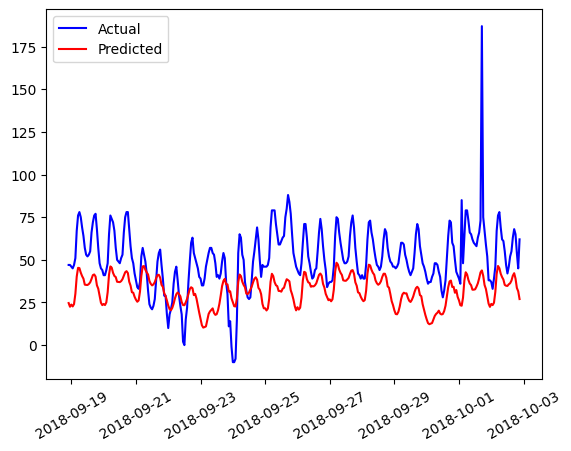

In [36]:
plt.plot(y_test_master.index, y_test_master, label="Actual", color="blue")
plt.plot(y_test_master.index, y_pred, label="Predicted", color="red")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Cross-validation way

In [37]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_error

In [38]:
tscv = TimeSeriesSplit(n_splits=5) # Split the data into 5 folds
model = LinearRegression()

In [39]:
scores = cross_val_score(
    model, X_train_master, y_train_master, cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

In [40]:
import numpy as np
rmse_scores = np.sqrt(-scores)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())

RMSE scores for each fold: [ 9.90069744  7.36622536 12.68037195 13.66658204 20.25081353]
Mean RMSE: 12.772938063716026
Std RMSE: 4.340693447033527


### Manual CV to plot the most representative fold

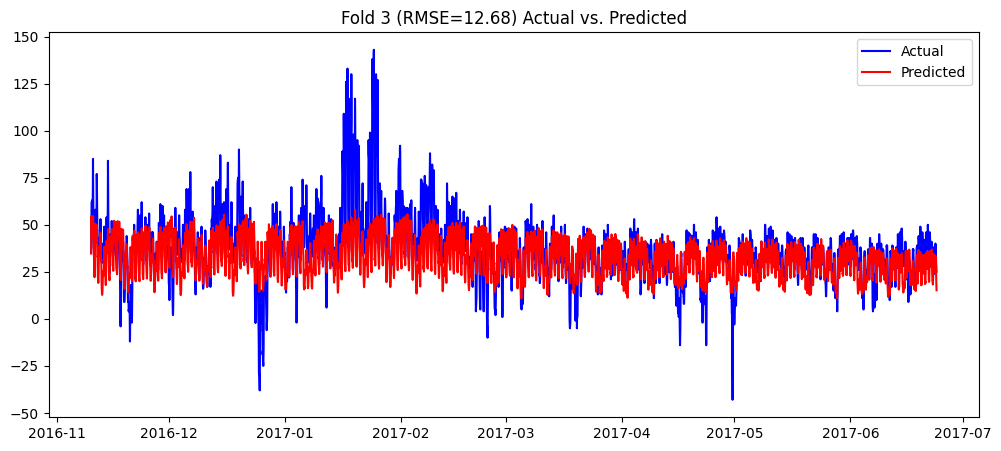

In [41]:
tscv_plot = TimeSeriesSplit(n_splits=5)
model_cv_plot = LinearRegression()

fold_rmse = []
fold_preds = []
fold_indices = []

for train_idx, test_idx in tscv_plot.split(X_train_master):
    model_cv_plot.fit(X_train_master.iloc[train_idx], y_train_master.iloc[train_idx])
    y_pred_fold = model_cv_plot.predict(X_train_master.iloc[test_idx])
    rmse = root_mean_squared_error(y_train_master.iloc[test_idx], y_pred_fold)
    fold_rmse.append(rmse)
    fold_preds.append(y_pred_fold)
    fold_indices.append(test_idx)

mean_rmse = np.mean(fold_rmse)
best_fold = np.argmin(np.abs(np.array(fold_rmse) - mean_rmse))

plt.figure(figsize=(12, 5))
plt.plot(y_train_master.iloc[fold_indices[best_fold]].index, y_train_master.iloc[fold_indices[best_fold]], label="Actual", color="blue")
plt.plot(y_train_master.iloc[fold_indices[best_fold]].index, fold_preds[best_fold], label="Predicted", color="red")
plt.title(f"Fold {best_fold+1} (RMSE={fold_rmse[best_fold]:.2f}) Actual vs. Predicted")
plt.legend()
plt.show()

### Coefficients

#### Raw Coefficients

In [42]:
for feature, coeff in zip(X_train_master.columns, model_cv_plot.coef_):
    print(f"{feature}: {coeff}")

AT_load_forecast_entsoe_transparency: 0.011067361307049712
AT_wind_onshore_lag24: -0.0017780129409971559
AT_solar_generation_lag24: -0.011678860672629155
AT_load_rolling24h: 0.010049442864692483
AT_load_ema24h: -0.016012372893046415
hour_sin: -6.745938133991471
hour_cos: 3.369772658152601
weekday_sin: 0.4903125760049365
weekday_cos: -1.3592249613712994


#### Normalized Coefficients

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_master)
X_test_scaled = scaler.transform(X_test_master)

model = LinearRegression()
model.fit(X_train_scaled, y_train_master)

for feature, coeff in zip(X_train_master.columns, model.coef_):
    print(f"{feature}: {coeff}")

AT_load_forecast_entsoe_transparency: 17.548856038110173
AT_wind_onshore_lag24: -1.1822365978356404
AT_solar_generation_lag24: 1.1155923250321318
AT_load_rolling24h: 14.434251743920639
AT_load_ema24h: -23.583783055711177
hour_sin: -7.280008317769368
hour_cos: 5.222871362383666
weekday_sin: 0.8430558345784173
weekday_cos: -1.4291728173117608


## ARIMA

### Static Forecasting Method

In [44]:
from statsmodels.tsa.arima.model import ARIMA

In [45]:
model_arima = ARIMA(y_train_master, order=(5,1,4))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:     AT_price_day_ahead   No. Observations:                32536
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -83886.952
Date:                Mon, 08 Dec 2025   AIC                         167793.903
Time:                        23:44:43   BIC                         167877.804
Sample:                    01-02-2015   HQIC                        167820.720
                         - 09-18-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4386      0.028     15.599      0.000       0.383       0.494
ar.L2          1.0197      0.034     29.710      0.000       0.952       1.087
ar.L3         -0.6452      0.023    -28.125      0.0

In [46]:
# print(train_arima)
print(y_train_master.mean())

33.77477255962626


In [47]:
in_smaple_preds_arima = model_arima_fit.predict()

rmse_arima = root_mean_squared_error(y_train_master, in_smaple_preds_arima)
mae_arima = mean_absolute_error(y_train_master, in_smaple_preds_arima)
print("RMSE: ", rmse_arima)
print("MAE: ", mae_arima)

RMSE:  3.1915626561116626
MAE:  2.1139560499176158


In [48]:
out_sample_forecast_arima = model_arima_fit.forecast(steps=len(y_test_master))

rmse_test_arima = root_mean_squared_error(y_test_master, out_sample_forecast_arima)
mae_test_arima = mean_absolute_error(y_test_master, out_sample_forecast_arima)

print("RMSE: ", rmse_test_arima)
print("MAE: ", mae_test_arima)

RMSE:  15.13564622655534
MAE:  10.426592569292879


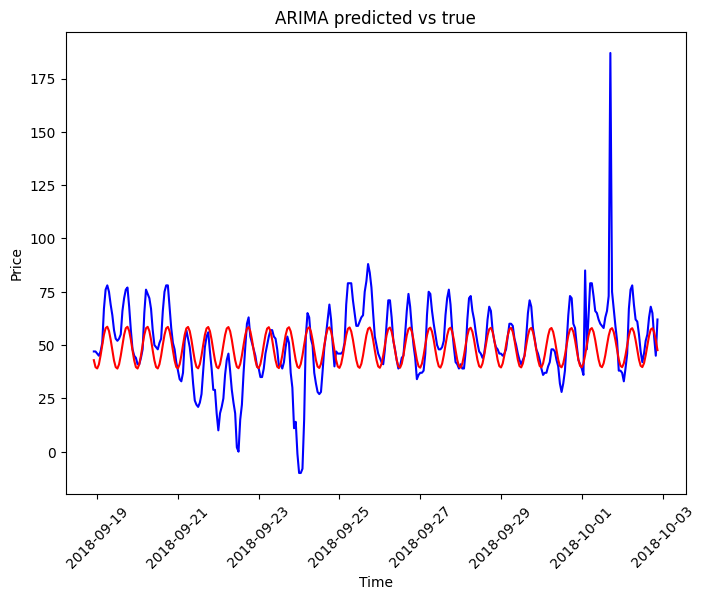

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(y_test_master.index, y_test_master, color="blue")
plt.plot(y_test_master.index, out_sample_forecast_arima, color="red")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("ARIMA predicted vs true")
plt.show()

### Rolling Window Forecasting Method

In [50]:
from pmdarima import auto_arima
auto_model = auto_arima(y_train_master, seasonal=False, trace=True)
print(auto_model.summary())
best_order = auto_model.order
# Fit ARIMA with best_order
model_arima = ARIMA(y_train_master, order=best_order).fit()
out_sample_forecast_arima = model_arima.forecast(steps=len(y_test_master))
out_sample_forecast_arima = pd.Series(out_sample_forecast_arima, index=y_test_master.index)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=170978.092, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186441.280, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=175051.542, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176621.276, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=186439.281, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=174102.324, Time=1.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=170998.964, Time=6.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=170958.027, Time=6.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=170976.573, Time=4.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=170978.588, Time=7.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=170956.370, Time=7.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=170970.318, Time=7.12 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=11.38 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=12.14 sec
 ARIMA(2,1,4)(0,0

/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Starting forecast for 336 hours...
Rolling Forecast RMSE: 16.62
Rolling Forecast MAE: 11.77


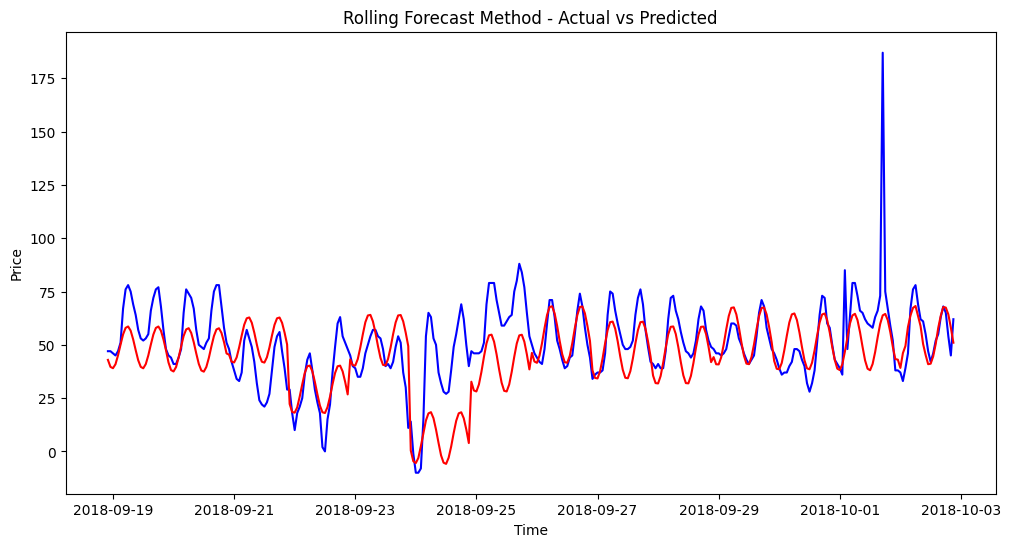

In [51]:
rolling_model = ARIMA(y_train_master, order=(5, 1, 4)).fit()

predictions = []
history = y_train_master.copy()
step_size = 24 # We iterate through the test data in steps of 24 hours (Day-Ahead)

print(f"Starting forecast for {len(y_test_master)} hours...")

for t in range(0, len(y_test_master), step_size):
    forecast = rolling_model.forecast(steps=step_size)

    predictions.extend(forecast)

    true_chunk = y_test_master[t: t + step_size]

    rolling_model = rolling_model.append(true_chunk, refit=False)

predictions = pd.Series(predictions, index=y_test_master.index)

rmse = root_mean_squared_error(y_test_master, predictions)
mae = mean_absolute_error(y_test_master, predictions)

print(f"Rolling Forecast RMSE: {rmse:.2f}")
print(f"Rolling Forecast MAE: {mae:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index,y_test_master, color="blue")
plt.plot(predictions.index, predictions, color="red")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Rolling Forecast Method - Actual vs Predicted")
plt.show()

#### The Rolling ARIMA model established a baseline RMSE of 16.62. While it successfully captured the daily seasonality and general trend, it failed to predict extreme outliers (like the Oct 2nd spike) because standard ARIMA lacks visibility into fundamental drivers like Wind and Load. This justifies the need for an ARIMAX/SARIMAX model or XGBoost to incorporate exogenous features.

### Use Sliding Window on train data (Get rid of stale data)

Starting Sliding Window Forecast (Refitting every 24 hours)...
Window Size: 8760 hours
Test Duration: 336 hours
Predicted step 0/336
Predicted step 24/336
Predicted step 48/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 72/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 96/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 120/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 144/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 168/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 192/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 216/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 240/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Predicted step 264/336


/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/petros/Projects/quant/quant_env/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted step 288/336
Predicted step 312/336
RMSE: 16.97035876344441
MAE: 12.072271729609934


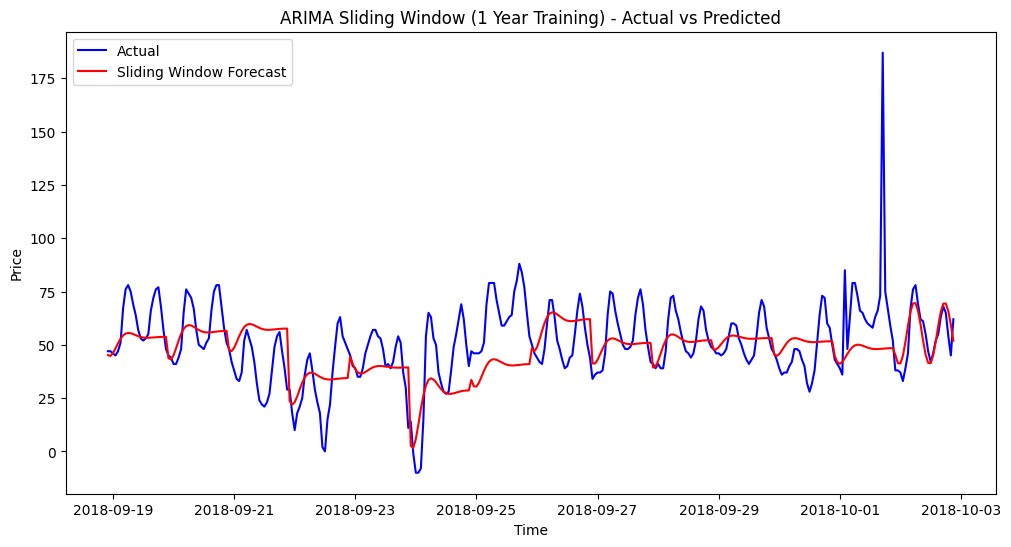

In [52]:
window_size = 24 * 365 # Keep last years data
forecast_horizon = 24 # Predict the next 24 hours
step_size = 24 # Move the window of train data by 24 hours

full_history = pd.concat([y_train_master, y_test_master])

test_start_index = len(y_train_master)
total_steps = len(y_test_master)

predictions = []
actuals = []

print(f"Starting Sliding Window Forecast (Refitting every {step_size} hours)...")
print(f"Window Size: {window_size} hours")
print(f"Test Duration: {total_steps} hours")

for t in range(0, total_steps, step_size):

    current_index = test_start_index + t

    window_start = current_index - window_size
    window_end = current_index

    train_rolling_arima = full_history.iloc[window_start : window_end]

    sliding_rolling_model = ARIMA(train_rolling_arima, order=(2, 1, 2)).fit()

    pred_values = sliding_rolling_model.forecast(steps=step_size) # Forecast

    predictions.extend(pred_values) # Store Results

    print(f"Predicted step {t}/{total_steps}")

predictions_series = pd.Series(predictions, index=y_test_master.index)

rmse = root_mean_squared_error(y_test_master, predictions_series)
mae = mean_absolute_error(y_test_master, predictions_series)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_master.index, y_test_master, label="Actual", color="blue")
plt.plot(predictions_series.index, predictions_series, label="Sliding Window Forecast", color="red")
plt.title("ARIMA Sliding Window (1 Year Training) - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

***

### 📝 Project Note: Conclusion on Vanilla ARIMA

**1. The Stability vs. Adaptability Finding**
> *"I hypothesized that a **Sliding Window** approach (training on the most recent 1 year) would outperform a **Full History** approach (training on 3+ years) by adapting to recent market regime changes (e.g., price level shifts from 2015 to 2018).
>
> However, experimental results proved the opposite:
> * **Full History (Rolling Update):** RMSE ~16.81 (Stable)
> * **Sliding Window (Daily Refit):** RMSE ~20.15 (Unstable)
>
> **Analysis:** The complex ARIMA structure (high order) requires significant data to stabilize its parameters. Reducing the training window to 1 year increased model **Variance** (instability/overfitting to noise) more than it reduced **Bias** (regime lag). Furthermore, while the *price levels* changed over the years, the underlying *autocorrelation structure* (intraday physics) remained sufficiently stable, making the older data valuable for training."*

**2. The "Univariate Ceiling"**
> *"Despite optimizing the window strategy, the Vanilla ARIMA model has reached a performance ceiling (RMSE ~16.8).
>
> **Limitations Identified:**
> * **Blindness to Fundamentals:** The model failed to predict the extreme price spike on October 2nd. This is expected, as Univariate ARIMA relies solely on past price history. It cannot see the exogenous drivers (e.g., a drop in Wind generation or a spike in Load) that caused the anomaly.
> * **Lack of Intraday Seasonality:** Without explicit time-based features, the model struggles to capture the precise hour-to-hour shape of the electricity curve (The 'Duck Curve')."*

**3. Next Steps**
> *"To break through this ceiling, I will transition to **Multivariate Models (ARIMAX / XGBoost)**. By incorporating **Exogenous Features** (Wind Generation, Load Forecast, and Time-of-Day), the model will shift from 'reacting to past price movements' to 'predicting based on fundamental market drivers'."*

***

## ARIMAX


In [53]:
# Simple Trading Strategy: 
# If Model predicts Price > X (high), we Sell (Short) expecting it to drop? 
# Or simpler: Day Ahead Trading Strategy.
# "If we predict price will be HIGHER than the naive baseline (yesterday), we Buy."

# Let's do a simple spread capture strategy simulation:
# We simulate a battery or speculative trader.
# Rule: If Predicted Price < 50 EUR (Cheap), BUY. If Predicted Price > 100 EUR (Expensive), SELL.

initial_cash = 10000
cash = initial_cash
inventory = 0
portfolio_value = []

print("--- Starting Backtest ---")

for date, price_actual, price_pred in zip(y_test_master.index, y_test_master, y_pred_xgb):
    
    # DECISION LOGIC (Based on PREDICTION, executed on ACTUAL)
    if price_pred < 40 and cash > price_actual: # Buy signal
        inventory += 1
        cash -= price_actual
        action = "BUY"
    elif price_pred > 100 and inventory > 0: # Sell signal
        inventory -= 1
        cash += price_actual
        action = "SELL"
    else:
        action = "HOLD"
    
    # Mark to Market Value
    current_val = cash + (inventory * price_actual)
    portfolio_value.append(current_val)

# Plot PnL
plt.figure(figsize=(15, 6))
plt.plot(y_test_master.index, portfolio_value)
plt.title(f"Trading Strategy PnL (End Value: €{portfolio_value[-1]:.2f})")
plt.ylabel("Portfolio Value (€)")
plt.show()

--- Starting Backtest ---


NameError: name 'y_pred_xgb' is not defined